In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
from tdc.single_pred import Tox
data = Tox(name = 'LD50_Zhu')
# split = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
# import pandas as pd
# import torch
# from torch_geometric.data import Data
# from rdkit import Chem
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# # Load dataset
# df = pd.read_csv('ld50_zhu.tab', sep='\t')

# # Atom feature function
# def atom_features(atom):
#     return torch.tensor([
#         atom.GetAtomicNum(),
#         atom.GetDegree(),
#         atom.GetFormalCharge(),
#         atom.GetHybridization().real,
#         atom.GetIsAromatic()
#     ], dtype=torch.float)

# # SMILES to graph
# def mol_to_graph_data(smiles, label):
#     mol = Chem.MolFromSmiles(smiles)
#     if mol is None:
#         return None

#     x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

#     edge_index = []
#     for bond in mol.GetBonds():
#         i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
#         edge_index += [[i, j], [j, i]]

#     edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#     y = torch.tensor([label], dtype=torch.float)
#     return Data(x=x, edge_index=edge_index, y=y)

# # Convert all data
# graph_data_list = []
# for _, row in tqdm(df.iterrows(), total=len(df)):
#     data = mol_to_graph_data(row['X'], row['Y'])
#     if data:
#         graph_data_list.append(data)

# # Split dataset
# train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)


import pandas as pd
import torch
from torch_geometric.data import Data
from rdkit import Chem
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from rdkit.Chem import rdchem

# Load dataset
df = pd.read_csv('ld50_zhu.tab', sep='\t')

# Helper function for one-hot encoding
def one_hot_encoding(value, choices):
    return [float(value == choice) for choice in choices]

# Atom feature function (enhanced)
def atom_features(atom):
    atom_type_list = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'H', 'Unknown']
    hybridization_list = [
        rdchem.HybridizationType.SP,
        rdchem.HybridizationType.SP2,
        rdchem.HybridizationType.SP3,
        rdchem.HybridizationType.SP3D,
        rdchem.HybridizationType.SP3D2
    ]

    symbol = atom.GetSymbol()
    symbol = symbol if symbol in atom_type_list else 'Unknown'

    features = []
    features += one_hot_encoding(symbol, atom_type_list)
    features += one_hot_encoding(atom.GetDegree(), list(range(6)))
    features.append(atom.GetFormalCharge())
    features += one_hot_encoding(atom.GetHybridization(), hybridization_list)
    features.append(float(atom.GetIsAromatic()))
    features += one_hot_encoding(atom.GetNumImplicitHs(), list(range(5)))
    features += one_hot_encoding(atom.GetChiralTag(), [
        rdchem.ChiralType.CHI_UNSPECIFIED,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
        rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
        rdchem.ChiralType.CHI_OTHER
    ])
    features.append(float(atom.IsInRing()))
    features.append(atom.GetMass() * 0.01)  # Scaled atomic mass

    return torch.tensor(features, dtype=torch.float)

# Bond feature function
def bond_features(bond):
    bond_type_list = [
        rdchem.BondType.SINGLE,
        rdchem.BondType.DOUBLE,
        rdchem.BondType.TRIPLE,
        rdchem.BondType.AROMATIC
    ]

    features = []
    features += one_hot_encoding(bond.GetBondType(), bond_type_list)
    features.append(float(bond.GetIsConjugated()))
    features.append(float(bond.IsInRing()))
    return torch.tensor(features, dtype=torch.float)

# SMILES to graph
def mol_to_graph_data(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = torch.stack([atom_features(atom) for atom in mol.GetAtoms()])

    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        f = bond_features(bond)
        edge_index += [[i, j], [j, i]]
        edge_attr += [f, f]  # Bidirectional edges

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.stack(edge_attr) if edge_attr else torch.empty((0, 0))

    y = torch.tensor([label], dtype=torch.float)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Convert all data
graph_data_list = []
for _, row in tqdm(df.iterrows(), total=len(df)):
    data = mol_to_graph_data(row['X'], row['Y'])
    if data:
        graph_data_list.append(data)

# Split dataset
train_data, test_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)



100%|██████████| 7385/7385 [00:08<00:00, 841.51it/s]


In [4]:
df

,ID,X,Y
0,"Diazene, diphenyl-, 1-oxide",[O-][N+](=Nc1ccccc1)c1ccccc1,2.505
1,"Methane, tribromo-",BrC(Br)Br,2.343
2,Bromoethene (9CI),C=CBr,2.330
3,"1,1'-Biphenyl, hexabromo-",Brc1ccc(-c2ccc(Br)c(Br)c2Br)c(Br)c1Br,1.465
4,"Isothiocyanic acid, p-bromophenyl ester",S=C=Nc1ccc(Br)cc1,2.729
...,...,...,...
7380,"Isocyanic acid, (alpha,alpha,alpha-trifluoro-o...",O=C=Nc1ccccc1C(F)(F)F,1.427
7381,"1,3-Benzenediamine, 4-(1,1,2,2-tetrafluoroetho...",Nc1ccc(OC(F)(F)C(F)F)c(N)c1,2.321
7382,"Propanenitrile, 3-((2-(acetyloxy)ethyl)phenyla...",CC(=O)OCCN(CCC#N)c1ccccc1,2.050
7383,"IH-Indene-1,3(2H)-dione, 2-(2-methyl-1-(2-(1-p...",CC1=CC(=C2C(=O)c3ccccc3C2=O)C=CN1CCN1CCCCC1,2.951


In [5]:
train_data[0].edge_index

tensor([[ 0,  1,  1,  2,  2,  3,  2,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,
          9, 10, 10, 11, 10, 12, 12, 13,  7, 14, 14, 15, 15, 16, 14, 17, 17,  4],
        [ 1,  0,  2,  1,  3,  2,  4,  2,  5,  4,  6,  5,  7,  6,  8,  7,  9,  8,
         10,  9, 11, 10, 12, 10, 13, 12, 14,  7, 15, 14, 16, 15, 17, 14,  4, 17]])

# Our Model Architecture :

In [6]:
# import torch.nn as nn
# import torch.nn.functional as F
# from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm

# class GCNRegressor(nn.Module):
#     def __init__(self, num_node_features, hidden_dim=64):
#         super(GCNRegressor, self).__init__()
        
#         # GCN layers with batch norm and dropout
#         self.conv1 = GCNConv(num_node_features, hidden_dim)
#         self.bn1 = BatchNorm(hidden_dim)
        
#         self.conv2 = GCNConv(hidden_dim, hidden_dim)
#         self.bn2 = BatchNorm(hidden_dim)

#         self.conv3 = GCNConv(hidden_dim, hidden_dim)
#         self.bn3 = BatchNorm(hidden_dim)

#         self.dropout = nn.Dropout(0.3)

#         # Fully connected layers
#         self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
#         self.fc2 = nn.Linear(hidden_dim // 2, 1)

#     def forward(self, x, edge_index, batch):
#         # First GCN block
#         x = self.conv1(x, edge_index)
#         x = self.bn1(x)
#         x = F.relu(x)
#         x = self.dropout(x)

#         # Second GCN block
#         x = self.conv2(x, edge_index)
#         x = self.bn2(x)
#         x = F.relu(x)
#         x = self.dropout(x)

#         # Third GCN block with residual connection
#         x_res = x
#         x = self.conv3(x, edge_index)
#         x = self.bn3(x)
#         x = F.relu(x + x_res)  # residual connection
#         x = self.dropout(x)

#         # Global pooling to get graph-level representation
#         x = global_mean_pool(x, batch)

#         # Regression head
#         x = F.relu(self.fc1(x))
#         x = self.fc2(x)

#         return x


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool, BatchNorm

class GCNRegressor(nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim=64):
        super(GCNRegressor, self).__init__()

        # Define neural networks for edge-conditioned convolution
        nn1 = nn.Sequential(
                nn.Linear(num_edge_features, hidden_dim * num_node_features),
                nn.ReLU(),
                nn.Linear(hidden_dim * num_node_features, hidden_dim * num_node_features)
            )

        nn2 = nn.Sequential(
            nn.Linear(num_edge_features, hidden_dim * hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim * hidden_dim, hidden_dim * hidden_dim)
        )

        nn3 = nn.Sequential(
            nn.Linear(num_edge_features, hidden_dim * hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim * hidden_dim, hidden_dim * hidden_dim)
        )
        # Edge-conditioned GCN layers (NNConv)
        self.conv1 = NNConv(num_node_features, hidden_dim, nn1, aggr='mean')
        self.bn1 = BatchNorm(hidden_dim)

        self.conv2 = NNConv(hidden_dim, hidden_dim, nn2, aggr='mean')
        self.bn2 = BatchNorm(hidden_dim)

        self.conv3 = NNConv(hidden_dim, hidden_dim, nn3, aggr='mean')
        self.bn3 = BatchNorm(hidden_dim)

        self.dropout = nn.Dropout(0.3)

        # Fully connected regression head
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # First NNConv block
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second NNConv block
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third NNConv block with residual connection
        x_res = x
        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = F.relu(x + x_res)
        x = self.dropout(x)

        # Graph-level pooling
        x = global_mean_pool(x, batch)

        # Regression head
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


In [8]:
# def train(model, loader, optimizer, criterion, device):
#     model.train()
#     total_loss = 0
#     for batch in loader:
#         batch = batch.to(device)
#         optimizer.zero_grad()
#         out = model(batch.x, batch.edge_index, batch.batch)
#         loss = criterion(out.view(-1), batch.y.view(-1))
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item() * batch.num_graphs
#     return total_loss / len(loader.dataset)

# def evaluate(model, loader, criterion, device):
#     model.eval()
#     total_loss = 0
#     with torch.no_grad():
#         for batch in loader:
#             batch = batch.to(device)
#             out = model(batch.x, batch.edge_index, batch.batch)
#             loss = criterion(out.view(-1), batch.y.view(-1))
#             total_loss += loss.item() * batch.num_graphs
#     return total_loss / len(loader.dataset)


def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)  # include edge_attr
        loss = criterion(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)  # include edge_attr
            loss = criterion(out.view(-1), batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = GCNRegressor(num_node_features=5).to(device)

num_node_features = graph_data_list[0].x.shape[1]
num_edge_features = graph_data_list[0].edge_attr.shape[1]

model = GCNRegressor(num_node_features, num_edge_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(1, 51):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')


Epoch 001: Train Loss = 1.1086, Val Loss = 0.6399
Epoch 002: Train Loss = 0.6852, Val Loss = 0.6177
Epoch 003: Train Loss = 0.6396, Val Loss = 0.5422
Epoch 004: Train Loss = 0.6154, Val Loss = 0.5970
Epoch 005: Train Loss = 0.5890, Val Loss = 0.5052
Epoch 006: Train Loss = 0.5763, Val Loss = 0.4915
Epoch 007: Train Loss = 0.5662, Val Loss = 0.4778
Epoch 008: Train Loss = 0.5638, Val Loss = 0.4848
Epoch 009: Train Loss = 0.5414, Val Loss = 0.5139
Epoch 010: Train Loss = 0.5504, Val Loss = 0.5488
Epoch 011: Train Loss = 0.5294, Val Loss = 0.4517
Epoch 012: Train Loss = 0.5326, Val Loss = 0.4948
Epoch 013: Train Loss = 0.5146, Val Loss = 0.4716
Epoch 014: Train Loss = 0.5175, Val Loss = 0.4580
Epoch 015: Train Loss = 0.5067, Val Loss = 0.5064
Epoch 016: Train Loss = 0.5048, Val Loss = 0.4475
Epoch 017: Train Loss = 0.4977, Val Loss = 0.4679
Epoch 018: Train Loss = 0.4874, Val Loss = 0.4752
Epoch 019: Train Loss = 0.4760, Val Loss = 0.4647
Epoch 020: Train Loss = 0.4816, Val Loss = 0.5243


📊 Evaluation Metrics on Test Set:
MAE  = 0.4793
MSE  = 0.4150
RMSE = 0.6442
R²   = 0.5355


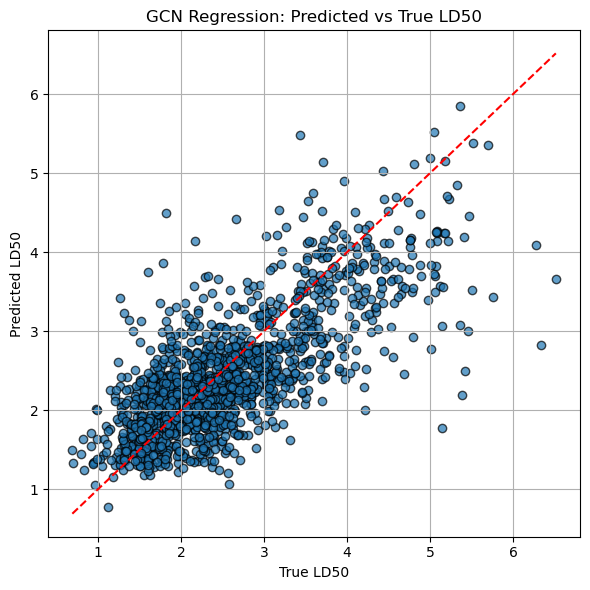

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch).view(-1)
            y_true.extend(batch.y.view(-1).cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_loader, device)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📊 Evaluation Metrics on Test Set:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True LD50")
plt.ylabel("Predicted LD50")
plt.title("GCN Regression: Predicted vs True LD50")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = "gcn_regressor_model_50.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to gcn_regressor_model_50.pth


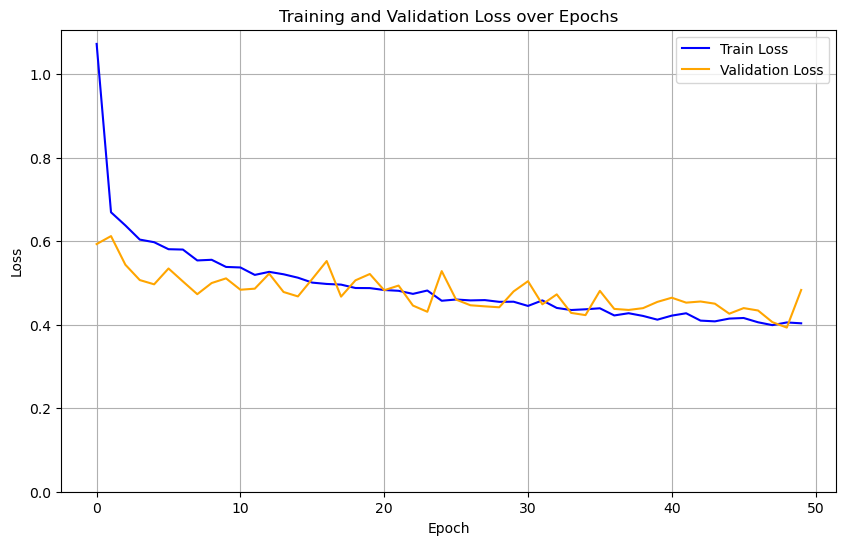

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, 201), train_losses, label='Train Loss', color='blue', linewidth=2)
# plt.plot(range(1, 201), val_losses, label='Validation Loss', color='orange', linewidth=2)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)

# Set y-axis to start at 0
plt.ylim(bottom=0)

plt.show()


In [ ]:
model_save_path = "gcn_regressor_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to gcn_regressor_model.pth


# GAT Architecture :

- GAT does not use edge features.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool, BatchNorm

class GATRegressor(nn.Module):
    def __init__(self, num_node_features, hidden_dim=64, heads=1):
        super(GATRegressor, self).__init__()

        self.conv1 = GATConv(num_node_features, hidden_dim, heads=heads)
        self.bn1 = BatchNorm(hidden_dim * heads)

        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads)
        self.bn2 = BatchNorm(hidden_dim * heads)

        self.conv3 = GATConv(hidden_dim * heads, hidden_dim, heads=heads)
        self.bn3 = BatchNorm(hidden_dim * heads)

        self.dropout = nn.Dropout(0.3)

        # Fully connected regression head
        self.fc1 = nn.Linear(hidden_dim * heads, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, x, edge_index, batch):
        # First GAT block
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GAT block
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third GAT block with residual
        x_res = x
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x + x_res)
        x = self.dropout(x)

        # Graph-level pooling
        x = global_mean_pool(x, batch)

        # Regression head
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


In [ ]:
def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)  # include edge_attr
        loss = criterion(out.view(-1), batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)  # include edge_attr
            loss = criterion(out.view(-1), batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs
    return total_loss / len(loader.dataset)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_node_features = graph_data_list[0].x.shape[1]
num_edge_features = graph_data_list[0].edge_attr.shape[1]

model = GATRegressor(num_node_features, num_edge_features).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(1, 101):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch:03d}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')


Epoch 001: Train Loss = 5.5288, Val Loss = 3.5424
Epoch 002: Train Loss = 1.5439, Val Loss = 0.8801
Epoch 003: Train Loss = 0.8575, Val Loss = 0.8427
Epoch 004: Train Loss = 0.8192, Val Loss = 0.7680
Epoch 005: Train Loss = 0.8129, Val Loss = 0.7527
Epoch 006: Train Loss = 0.7807, Val Loss = 0.7046
Epoch 007: Train Loss = 0.7717, Val Loss = 0.7107
Epoch 008: Train Loss = 0.7431, Val Loss = 0.6953
Epoch 009: Train Loss = 0.7358, Val Loss = 0.6928
Epoch 010: Train Loss = 0.7273, Val Loss = 0.7203
Epoch 011: Train Loss = 0.7134, Val Loss = 0.6811
Epoch 012: Train Loss = 0.7166, Val Loss = 0.6966
Epoch 013: Train Loss = 0.7030, Val Loss = 0.6402
Epoch 014: Train Loss = 0.6859, Val Loss = 0.6749
Epoch 015: Train Loss = 0.6798, Val Loss = 0.6363
Epoch 016: Train Loss = 0.6816, Val Loss = 0.6762
Epoch 017: Train Loss = 0.6845, Val Loss = 0.6112
Epoch 018: Train Loss = 0.6751, Val Loss = 0.6378
Epoch 019: Train Loss = 0.6660, Val Loss = 0.6302
Epoch 020: Train Loss = 0.6645, Val Loss = 0.6468


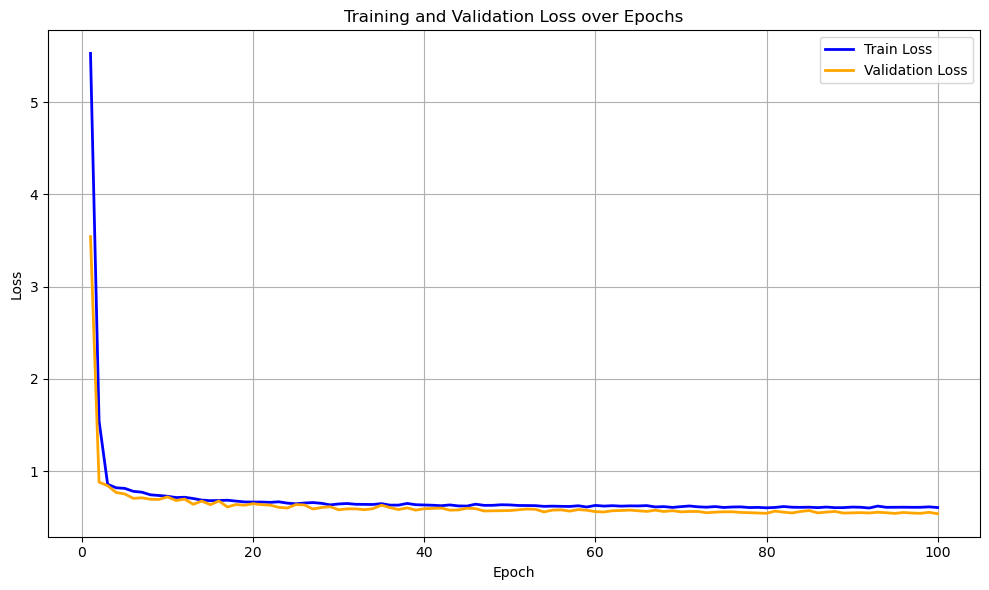

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(range(1, 101), val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 Evaluation Metrics on Test Set:
MAE  = 0.5469
MSE  = 0.5383
RMSE = 0.7337
R²   = 0.3975


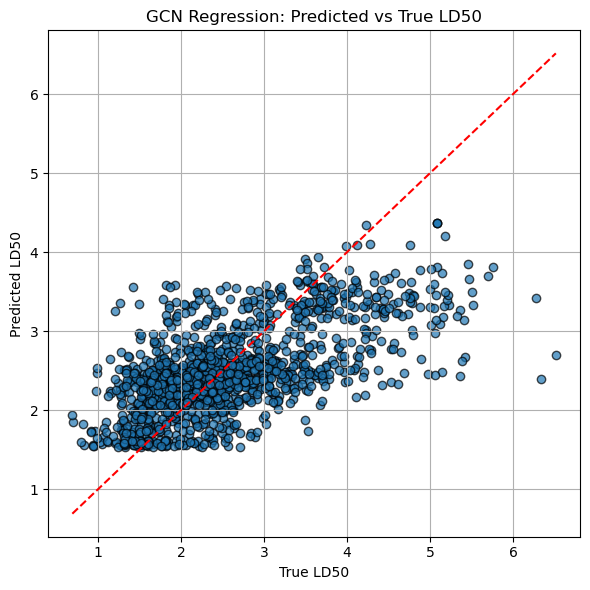

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def get_predictions(model, loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            preds = model(batch.x, batch.edge_index, batch.batch).view(-1)
            y_true.extend(batch.y.view(-1).cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return np.array(y_true), np.array(y_pred)

y_true, y_pred = get_predictions(model, test_loader, device)

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"📊 Evaluation Metrics on Test Set:")
print(f"MAE  = {mae:.4f}")
print(f"MSE  = {mse:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"R²   = {r2:.4f}")

plt.figure(figsize=(6, 6))
plt.scatter(y_true, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True LD50")
plt.ylabel("Predicted LD50")
plt.title("GCN Regression: Predicted vs True LD50")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model_save_path = "gat_regressor_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to gat_regressor_model.pth
